<font size="6" color="green"><b>PROJECT-4.</b> Увеличение среднего чека (EdTech)</font>

<font size="4" color="green"><b> Цель работы:  </b></font><br>
Подготовить основу рекомендательной системы. <br><br>
<font size="4" color="green"><b> Поставленная задача:  </b></font> <br>
Продакт-менеджер онлайн-школы *MasterMind* ожидает получить от вас **рекомендательную систему**, благодаря которой можно будет предлагать клиентам интересные им курсы и тем самым повышать средний чек.


<font size="4" color="green"><b> КОНКРЕТНЫЕ ШАГИ (ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ)</b></font> <br>

* Познакомиться с датасетом, подготовить и проанализировать данные с помощью SQL.
* Обработать данные средствами Python.
* Составить итоговую таблицу с рекомендациями (курсам будет
соответствовать по две рекомендации), снабдив её необходимыми комментариями, и представить отчёт продакт-менеджеру.

<font size="4" color="green"><b> Исходные данные (PGSQL)</b></font> <br>
Таблица **carts** — данные о пользовательских корзинах
* Promo Code ID — ID промокода, если он есть
* Purchased At — дата оплаты
* User ID — ID пользователя
* Created At — дата создания корзины
* Updated At — дата последнего обновления информации
* ID — идентификатор корзины
* State — состояние оплаты

Таблица **cart_items** — данные о курсах, которые пользователи добавили в корзину
* Created At — дата создания события
* Resource Type — тип продукта
* Resource ID — ID курса
* Cart ID — идентификатор корзины
* Updated At — дата последнего обновления информации
* ID — идентификатор операции

## 1. Импорт библиотек

In [23]:
import pandas as pd
import psycopg2 
import matplotlib.pyplot as plt
from scipy import stats as st

## 2. Загрузка данных из БД, определение основных размерностей данных

In [24]:
# Запрос формирует CTE sales_data для загрузки данных о продажах курсов:
# - ID клиента
# - ID курса
# - ID корзины
# - время покупки

req_sales_data = '''
with sales_data as(
select 
	c.user_id,
	ci.resource_id,
	c.id,
	c.updated_at
from 
	final.carts c 
	join final.cart_items ci on c.id = ci.cart_id  
where
	c.state = 'successful' and ci.resource_type = 'Course'
)
'''
# имена полей для выгрузки результата запроса в датафрейм
cols_sales_data = ['user_id','course_id','cart_id','selltime']

# запрос на получение полной таблицы из CTE sales_data
req_load = "select * from sales_data"

In [25]:
# функция db_req - загрузка данных из БД PostgresQL. 
# аргументы: 
#   - sql_req: строка, содержащая SQL-запрос к БД 
#   - col_names: имена столбцов для получаемого из запроса датафрейма
# возвращаемое значение:
#   - таблица, полученная в результате работы запроса, в формате pandas.Dataframe 

def db_req(sql_req, col_names):
    # попытка подключения к базе....
    try:
        print('Connecting to DB...')
        db_connection = psycopg2.connect(dbname='', 
                                         user='',
                                         host='',
                                         password='',
                                         port=5432)
        
    except psycopg2.DatabaseError as db_err:    # обработка ошибки подключения к БД
        print('Error:', db_err)
        return 
    else:                                       # подключение успешно...
        print('Connection established.')
        # попытка обработать запрос к БД
        try:
            db_cursor = db_connection.cursor()
            db_cursor.execute(sql_req)          # выполнение SQL запроса
            
        except psycopg2.Error as req_err:       # обработка ошибки запроса
            print('REQ Error: ', req_err)
            return
        else:                                   # запрос успешен, загружаем результат в датафрейм
            req_table = pd.DataFrame(db_cursor.fetchall(), 
                                     columns=col_names)
            print('REQ successful.') 
        finally:
            db_cursor.close()                   # финал обработки запроса - закрываем курсор
            db_connection.close()               # и закрываем подключения к БД
            print('Connection closed.') 
    return req_table

In [26]:
df_sales_data = db_req(req_sales_data + req_load, cols_sales_data) # загрузка в датафрейм данных по продажам курсов

Connecting to DB...
Connection established.


REQ successful.
Connection closed.


<font size="4" color="green"><b>Сколько клиентов покупали курсы?</b></font>

In [27]:
# запрос получения количества клиентов из CTE sales_data
req_cli_count = '''
select
	count(distinct user_id) 
from sales_data
'''
# имена полей для выгрузки результата запроса в датафрейм
cols_cli_count = ['cli_count']

db_req(req_sales_data + req_cli_count, cols_cli_count)

Connecting to DB...
Connection established.
REQ successful.
Connection closed.


,cli_count
0,49006


<font size="4" color="green"><b>Сколько всего есть различных курсов?</b></font>

In [28]:
# запрос получения количества курсов из справочника товаров
req_course_count = '''
select 
    count(distinct ci.resource_id) 
from 
    final.cart_items ci 
where 
    ci.resource_type = 'Course'
'''
# имена полей для выгрузки результата запроса в датафрейм
cols_course_count = ['course_count']

db_req(req_course_count, cols_course_count)

Connecting to DB...
Connection established.
REQ successful.
Connection closed.


,course_count
0,127


<font size="4" color="green"><b> Каково среднее число купленных курсов на одного клиента?</b></font>

In [29]:
# запрос формирует CTE cnt_courses для получения количества приобретенных курсов 
# каждым пользователем, из CTE sales_data
req_users_courses_cnt = '''
, 
cnt_courses as (
select 
	 count(distinct resource_id) as courses
from sales_data
group by user_id
)
'''
# запрос получает среднее количество курсов на клиента из CTE cnt_courses
# округление - сотые
req_avg_courses_cnt = '''
select 
	round(avg(courses),2)
from cnt_courses
'''
# имена полей для выгрузки результата запроса в датафрейм
cols_avg_courses_count = ['Average_courses_count']

db_req(req_sales_data + 
       req_users_courses_cnt + 
       req_avg_courses_cnt, 
       cols_avg_courses_count)

Connecting to DB...
Connection established.
REQ successful.
Connection closed.


,Average_courses_count
0,1.44


<font size="4" color="green"><b> Сколько клиентов купили больше одного курса?</b></font>

In [30]:
# запрос получает количество клиентов, купивших более 1 курса из CTE cnt_courses
req_regular_users = '''
select 
	count(courses)
from cnt_courses
where 	
	courses > 1
'''
# имена полей для выгрузки результата запроса в датафрейм
cols_reg_users = ['Regular_users']

db_req(req_sales_data + 
       req_users_courses_cnt + 
       req_regular_users, 
       cols_reg_users)

Connecting to DB...
Connection established.
REQ successful.
Connection closed.


,Regular_users
0,12656


Видим невысокую лояльность пользователей, только каждый четвертый приобрел более 1 курса. Среднее количество курсов на покупателя также невысокое - 1,44.

## 3. Анализ полученных из БД данных

<font size="4" color="green"><b> Сколько различных пар курсов встречаются вместе в покупках клиентов?</b></font>

In [31]:
# делаем копию датафрейма продаж
df_user_courses = df_sales_data.drop(['cart_id','selltime'],axis=1)

# строим полное пересечение пар курсов пользователей
df_pairs_all = pd.merge(df_user_courses,
                        df_user_courses,
                        how='outer',
                        on='user_id')

# формируем маски для фильтрации повторов в полученном пересечении
musk_A = df_pairs_all['course_id_x'] != df_pairs_all['course_id_y']
musk_B = df_pairs_all['course_id_x'] < df_pairs_all['course_id_y']

# применяем маски, группируем по парам курсов, считаем количество уникальных пар
df_pairs = df_pairs_all[musk_A & musk_B]. \
    groupby(by=['course_id_x','course_id_y']).nunique().reset_index()

print('Возможных пар курсов в покупках: ',df_pairs.shape[0])

Возможных пар курсов в покупках:  3989


<font size="4" color="green"><b> Найдите самую популярную пару курсов. Какие у них ID? </b></font>

In [32]:
# переименуем столбец с количеством покупок для дальнейшего удобства
df_pairs = df_pairs.rename(columns={'user_id':'sales'})

print('Самая популярная пара курсов:' )
print(df_pairs.sort_values(by=['sales'],
                           ascending=False).iloc[0]['course_id_x'])
print(df_pairs.sort_values(by=['sales'],
                           ascending=False).iloc[0]['course_id_y'])

Самая популярная пара курсов:
551
566


Посмотрим поближе на распределение популярности пар курсов.

In [33]:
#получим статистику по продажам
df_pairs['sales'].describe()

count    3989.000000
mean       10.031838
std        26.355998
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       797.000000
Name: sales, dtype: float64

In [34]:
# Тест Шапиро-Уилка для нулевой гипотезы о нормальном распределении данных
shapiro = st.shapiro(df_pairs['sales'])
print(shapiro)

ShapiroResult(statistic=0.31442534923553467, pvalue=0.0)


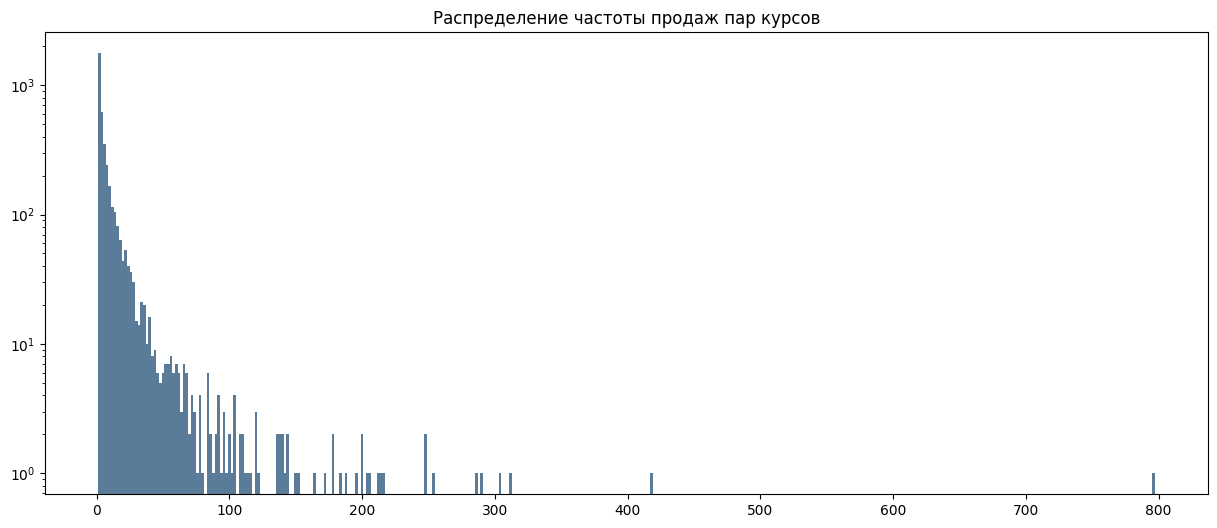

In [35]:
bin_count = int(df_pairs.shape[0]/10)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
axes.hist(df_pairs['sales'],
          bins=bin_count,
          color = 'xkcd:slate blue'
          )
axes.set_title('Распределение частоты продаж пар курсов')
plt.yscale('log')
plt.show()

Что следует отметить:
- Распределение далеко от нормального;
- Среднее количество продаж пар курсов - 10 (а это значение за 75% процентилем), при этом стандартное отклонение около 26. Имеется значительный разброс от среднего обусловленный тем, что объем продаж пар-бестселлеров носит характер статистических выбросов;
- В данных имеется значительное количество малопопулярных пар курсов среди приобретенных, половина из пар приобреталась не более 3 раз.

В целом, подтверждается утверждение продакт-менеджера о низкой популярности значительной части курсов онлайн-школы *MasterMind*. 

## 4. Формирование таблицы рекомендаций.

Итак, мы получили набор пар неких проданных курсов. Наличие пары курсов (назовем их курсами $X$ и $Y$, где $Y$ - рекомендуемый в пару к $X$) в нашем сете, в отсутствие иной информации, говорит о том, что для клиентов *MasterMind* имеется некая логическая связанность $X$ и $Y$, обосновывающая их приобретение условным (поскольку они могут приобретаться в различное время) комплектом. Чем чаще комплекты $X+Y$ приобретались, тем шире круг пользователей, для которых очевидно наличие этой связи, а для нас вероятность продать пару курсов комплектом (назовем этот признак "*связанность*"). Таким образом, частота продаж комплекта $X+Y$ является значимым показателем для формирования парной рекомендации. 

Однако, статистика имеющихся данных говорит о том, что значительный объем продаж составляют единичные пары. Рекомендацию для курса с небольшими разовыми продажами пар потребуется вырабатывать на дополнительных показателях. Другим вариантом решения является замена малопопулярных пар на новые, где рекомендуемый курс Y имеет значительные продажи, но никогда не продавался с курсом $X$. Последний вариант имеет изъян - неочевидна потребность пользователей в паре $X+Y$, ведь она никогда не покупалась. 

С учетом этих соображений, текущая рекомендательная система для малопопулярных пар будет использовать дополнительный признак - количество вариантов пар, в которых продавался курс $Y$. Значительное количество таких пар укажет на хороший потенциал продать этот курс в пару к другому (назовем его "*впариваемость*"). В практическом плане мы максимизируем индексы связанности и впариваемости. 

In [36]:
# Построим "симметричный" датафрейм с количеством проданных пар курсов. 
# Под симметричностью здесь понимается наличие одной проданной
# пары в двух экземплярах - пара X+Y и пара Y+X

df_rec = df_pairs_all[musk_A]. \
    groupby(by=['course_id_x','course_id_y']).nunique().reset_index()

In [37]:
# Теперь добавим признак "впариваемости" для курса Y:
df_rec['y_pairs_total'] = df_rec.groupby(['course_id_y'])['course_id_x'].transform('count')

# для удобства переименуем поля более логичным образом:
df_rec = df_rec.rename(columns={'user_id':'xy_pairs_sold'})

# Сортируем таблицу по убыванию, сначала по номеру курса X, 
# далее по количеству проданных пар с курсом Y, (связанность)
# и по количеству пар, в которых продавался курс Y (впариваемость Y).
df_rec = df_rec.sort_values(by=['course_id_x', 'xy_pairs_sold','y_pairs_total'], ascending=False).reset_index()
df_rec.head()

,index,course_id_x,course_id_y,xy_pairs_sold,y_pairs_total
0,7975,1201,1125,1,77
1,7974,1201,571,1,75
2,7976,1201,1144,1,53
3,7977,1201,1186,1,44
4,7971,1200,794,1,107


Итак, имеем таблицу с интересующими нас признаками. Статистику продаж пар рассмотрели уже выше. Обратимся к статистике показателя впариваемости:

In [38]:
# Сформируем серию с количеством пар, образованным каждым курсом при продаже
df_pairability = df_rec.groupby(['course_id_y'])['y_pairs_total'].mean()
# получим статистику по серии:
df_pairability.describe()

count    126.000000
mean      63.317460
std       28.667934
min        3.000000
25%       44.250000
50%       64.000000
75%       80.000000
max      117.000000
Name: y_pairs_total, dtype: float64

Сейчас мы видим невысокий минимальный уровень, по итогам отбора лучших 2 рекомендаций он должен значительно увеличиться.

Пора проверить предположение о том, что количество пар, в которые попал рекомендуемый курс (показатель впариваемости) указывает на потенциальный успех в продажах. Рассчитаем ранговую корреляцию Спирмена показателя впариваемости и количества продаж курса в целом (как с другими курсами, так и поодиночке). 

In [39]:
# В датафрейм df_bulk_sales загрузим количество продаж курсов в целом.
df_bulk_sales = df_sales_data.groupby(['course_id'])['user_id'].nunique().reset_index()

st.spearmanr(df_pairability,df_bulk_sales['user_id'])

SignificanceResult(statistic=0.7944493937923574, pvalue=1.2502419480349456e-28)

Коэффициент корреляции $0.79$ при p-value $1.25*10^{-28}$. Можем пользоваться нашим допущением.

Проведем сокращение датафрейма df_rec до 2 рекомендованных пар. Поскольку она отстортирована по убыванию, просто оставляем 2 первых парных курса.

In [40]:
# формируем и сортируем датафрейм с показателем связанности
# (продано пар X+Y) по убыванию: 
pairs_count = df_rec['course_id_x'].value_counts(). \
                to_frame().sort_values(by=['course_id_x'],ascending=False)

# счетчик позиции текущего курса в датафрейме 
pos = 0
# список позиций удаляемых строк, инициализируется пустым
droplist = list()
# в цикле проходим по количеству курсов, проданных с курсом X в паре
for Xpairs in pairs_count.iloc[:,0]:
    # добавляем в список на удаление все пары, кроме первых двух
    droplist += list(range(pos+2,pos+Xpairs))
    # прибавляем к текущей позиции количество пар
    pos = pos + Xpairs 

# удаляем пары курсов с минимальными продажами    
df_rec = df_rec.drop(droplist)

In [41]:
# Посмотрим на статистику рекомендуемых курсов
df_rec.groupby(['course_id_y'])['y_pairs_total'].mean().describe()

count     55.000000
mean      79.327273
std       21.895420
min       37.000000
25%       64.000000
50%       76.000000
75%      101.000000
max      117.000000
Name: y_pairs_total, dtype: float64

Итак, рекомендуемые курсы имеют достаточно высокий показатель впариваемости. Среднее значение 79, медиана 76. Можем прогнозировать высокий потенциал продаж для рекомендаций. 

Осталось привести датафрейм в требуемый продакт-менеджером вид.

In [42]:
# В нашем датафрейме данные уже отсортированы по признакам,
# соответственно нужно выделить первую рекомендацию 
# из нечетных строк, а вторую - из четных (столбец course_id_y)

# удалим ненужные уже столбцы
df_rec = df_rec.drop(['xy_pairs_sold','y_pairs_total','index'],axis=1)

# выделяем в датафрейм первые рекомендации
df_left = df_rec.loc[::2,:]

# ... и вторые - в другой датафрейм
df_right = df_rec.loc[1::2,:]

# собираем в один датафрейм:
df_rec = pd.merge(df_left,
                  df_right,
                  on='course_id_x',
                  suffixes=['_1st','_2nd'],
                  how='left'
                  )

In [43]:
df_rec.head()

,course_id_x,course_id_y_1st,course_id_y_2nd
0,1201,1125,571
1,1200,794,1104
2,1199,523,515
3,1198,571,551
4,1188,1141,513


<style> p {font-family: Segoe Print, Segoe Script}</style>
<p>Дорогой продакт-менеджер!

Предложенная здесь система рекомендаций достаточно проста в реализации и легко масштабируема, её достоинство в том, что она построена на подтвержденном историей покупок интересе покупателей ко второму курсу. 

Недостаток данной системы - её эффективность зависит от величины индекса впариваемости курсов. Она малопригодна в ситуациях, когда, например, предлагаются курсы по значительному количеству обособленных тематик, и по каждой тематике ассортимент ограничен единицами курсов (здесь кросс-продажи в принципе сильно осложнены).

Ваш М.К.
</p>

